In [3]:
import pandas as pd
import numpy as np
from tqdm import trange

import os

from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import seaborn as sns
import tqdm
from IPython.display import clear_output

py.init_notebook_mode(connected=True)

EQUAL_ASPECT_RATIO_LAYOUT = dict(
    margin={
        'l': 0,
        'r': 0,
        'b': 0,
        't': 0
    }, scene=dict(
    aspectmode='data'
))

%matplotlib inline

In [4]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

In [5]:
df = pd.read_csv('data.csv')

In [6]:
df.head(5)

,scene_id,x,y,z,intensity,ring,label
0,0,-11.355618,-4.206962,0.344085,0.0,23.0,1.0
1,0,-5.916535,-1.972164,0.283262,0.0,25.0,1.0
2,0,-7.410451,-2.113039,2.137792,0.0,31.0,1.0
3,0,-13.845870,-1.406652,0.406310,0.0,23.0,1.0
4,0,-8.326218,-0.346060,0.226469,0.0,22.0,1.0


### 1. Визуализация сцены

Красные точки это снег, синие точки это не снег

In [7]:
def plot_scene(df, id):

    new_df = df[df.scene_id == id]

    def color(label):
        return 'red' if label else 'blue'

    #scene, ohe_labels = scene_tuple
    labels = new_df.label
    fig = go.Figure(layout=EQUAL_ASPECT_RATIO_LAYOUT)
    fig.add_scatter3d(**{
        'x': new_df.x,
        'y': new_df.y,
        'z': new_df.z,
        'mode': 'markers',
        'marker': {
            'size': 1,
            'color': list(map(color, labels)),
        },
        'text': labels
    })
    fig.show(renderer='colab')

scene_id = 100 # номер сцены, которую визиализируем
plot_scene(df, scene_id)

Если не грузиться сцена, то вот картинка того, что должно выводиться

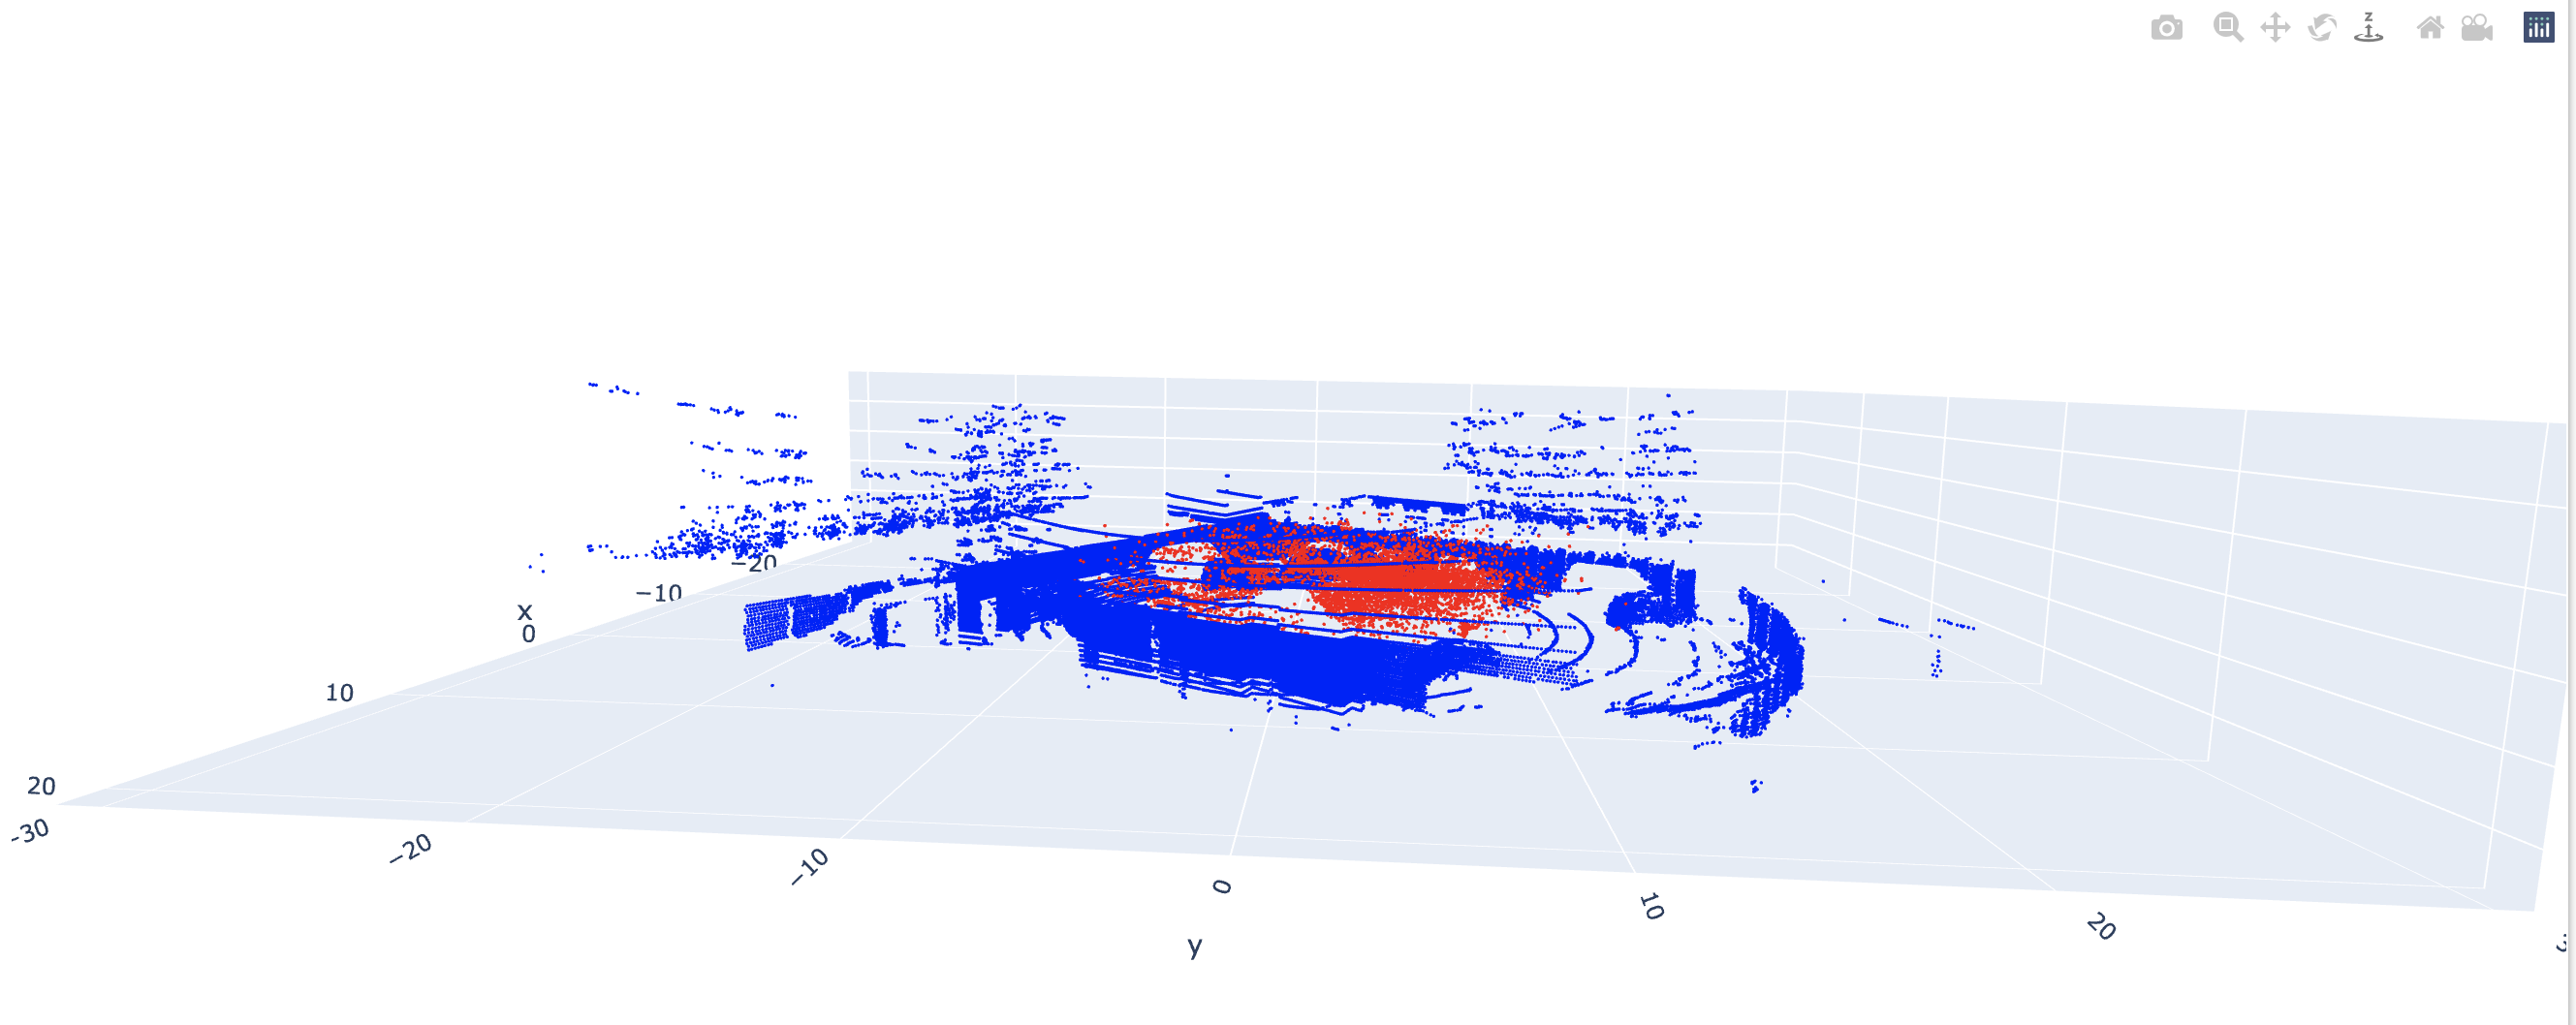

### 2. Изучение данных

#### 2.1 Информация о сценах

In [8]:
len(df.scene_id.unique()) # количество сцен в датасете

230

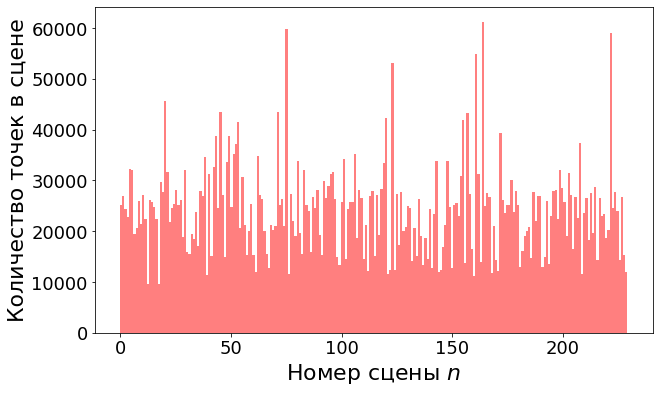

In [9]:
plt.hist(df.scene_id.ravel(), bins=230, color = 'Red', alpha = 0.5)
plt.xlabel('Номер сцены $n$')
plt.ylabel('Количество точек в сцене')
plt.show()

Как видно количество точек в каждой сцене примерно одинаковое

#### 2.2 Информация о координатах

Для этого нормализуем координаты в каждой сцене используя min_max нормализацию

In [10]:
from tqdm import tqdm

def generate_feature(df):
  ans_df = pd.DataFrame()
  scenes = np.unique(df.scene_id.values)
  for scene_id in tqdm(scenes): # начинаем ходить по каждой сцене
    df_scene_id = df[df.scene_id == scene_id] # берем все данные из этой сцены 
    eps = 0.001 
    df_scene_id["x_normailized"] = (df_scene_id.x - df_scene_id.x.min()) / (df_scene_id.x.max() - df_scene_id.x.min() + eps)
    df_scene_id["y_normailized"] = (df_scene_id.y - df_scene_id.y.min()) / (df_scene_id.y.max() - df_scene_id.y.min() + eps)
    df_scene_id["z_normailized"] = (df_scene_id.z - df_scene_id.z.min()) / (df_scene_id.z.max() - df_scene_id.z.min() + eps)

    ans_df = ans_df.append(df_scene_id)
  return ans_df

In [11]:
df_normalized = generate_feature(df)

100%|██████████| 230/230 [00:29<00:00,  7.68it/s]


In [13]:
df_normalized[["x_normailized", "y_normailized", "z_normailized", "label"]].groupby(["label"]).mean()

,x_normailized,y_normailized,z_normailized
label,,,
0.0,0.533780,0.505485,0.158682
1.0,0.507169,0.499346,0.337807


In [14]:
df_normalized[["x_normailized", "y_normailized", "z_normailized", "label"]].groupby(["label"]).std()

,x_normailized,y_normailized,z_normailized
label,,,
0.0,0.209038,0.221362,0.105581
1.0,0.124065,0.111849,0.105687


По этой информации можно сделать вывод, что снег в среднем находиться выше, чем другие точки, потому z_normailized больше для label = 1, чем z_normailized для label = 0.

Также дисперсия для снега меньше, чем у обычных точек, из этого можно сделать вывод, что снег скапливается в одном месте, а не "раскидан" по всей сцене.

Чтобы убедиться в этом построим паирплот для любой сцены

In [15]:
temp_df_1 = df_normalized[df_normalized.scene_id == 1]

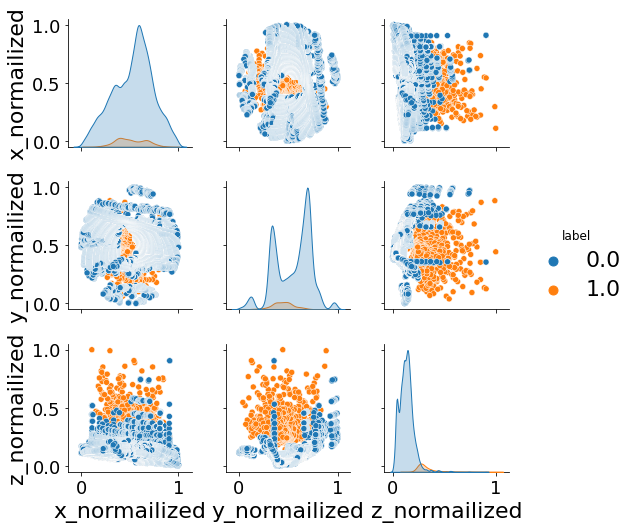

In [16]:
sns.pairplot(temp_df_1[["x_normailized", "y_normailized", "z_normailized", "label"]], hue="label")

Как видим паирплот подтверждает эту информацию визуально

#### 2.3 Номер луча

In [17]:
len(df.ring.unique())

40

In [18]:
df_normalized.corr()

,scene_id,x,y,z,intensity,ring,label,x_normailized,y_normailized,z_normailized
scene_id,1.000000,0.004924,0.002823,-0.027941,-0.009448,-0.033182,-0.011853,0.002348,0.002815,0.018179
x,0.004924,1.000000,-0.003737,-0.085102,-0.034557,-0.050379,-0.032163,0.995505,-0.003529,-0.075411
y,0.002823,-0.003737,1.000000,-0.109385,0.017933,-0.039352,-0.004195,-0.005351,0.996431,-0.119205
z,-0.027941,-0.085102,-0.109385,1.000000,-0.058342,0.477571,0.485894,-0.082995,-0.107582,0.856076
intensity,-0.009448,-0.034557,0.017933,-0.058342,1.000000,-0.174116,-0.294155,-0.025674,0.021177,-0.096968
ring,-0.033182,-0.050379,-0.039352,0.477571,-0.174116,1.000000,0.330937,-0.061835,-0.043118,0.465953
label,-0.011853,-0.032163,-0.004195,0.485894,-0.294155,0.330937,1.000000,-0.040433,-0.008863,0.461724
x_normailized,0.002348,0.995505,-0.005351,-0.082995,-0.025674,-0.061835,-0.040433,1.000000,-0.005568,-0.071131
y_normailized,0.002815,-0.003529,0.996431,-0.107582,0.021177,-0.043118,-0.008863,-0.005568,1.000000,-0.117656
z_normailized,0.018179,-0.075411,-0.119205,0.856076,-0.096968,0.465953,0.461724,-0.071131,-0.117656,1.000000


Как видим, ring и z_normailized имеют высокую корреляцию. Это связано с тем как работает лидар. Для сбора датасета использовался лидар, который выпускал 40 лучей под разными углами к горизонту, поэтому чем выше угол у луча, т.е. его номер, тем будет больше координата z в которую этот луч врежется

#### 2.4 Интенсивность

In [19]:
len(df.intensity.unique())

255

In [20]:
df_normalized[["intensity", "label"]].groupby(["label"]).mean()

,intensity
label,
0.0,17.215859
1.0,0.345636


In [21]:
df_normalized[["intensity", "label"]].groupby(["label"]).std()

,intensity
label,
0.0,17.776614
1.0,1.163935


По этой информации можно сделать вывод, что снег в среднем намного тусклее и эта тусклость находиться около 0.